In [129]:
import pandas as pd
import numpy as np

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [130]:
diets = pd.read_csv('subreddits.csv')

#### Check for data types

In [131]:
diets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5159 entries, 0 to 5158
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      5159 non-null   object 
 1   score      5159 non-null   int64  
 2   id         5159 non-null   object 
 3   url        5159 non-null   object 
 4   comms_num  5159 non-null   int64  
 5   created    5159 non-null   float64
 6   body       3410 non-null   object 
 7   subreddit  5159 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 322.6+ KB


In [132]:
diets.isnull().sum()

title           0
score           0
id              0
url             0
comms_num       0
created         0
body         1749
subreddit       0
dtype: int64

In [133]:
diets['title'] = diets['title'].str.replace('[^\w\s]', '') # remove punctuation
diets['title'] = diets['title'].str.replace('\d+', '') #remove digits

In [134]:
X = diets['title']
y = diets['subreddit']

In [135]:
# from: https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42, stratify = y)

In [137]:
cvec = CountVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode',  
                                stop_words = 'english',
                                lowercase = True, 
                                max_df = 0.5, 
                                min_df = 10) 

In [138]:
cvec.fit(X_train)

C:\Users\mason\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\mason\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CountVectorizer(max_df=0.5, min_df=10, stop_words='english',
                strip_accents='unicode',
                tokenizer=<__main__.LemmaTokenizer object at 0x000002966C019AC0>)

In [139]:
X_train = cvec.transform(X_train)

In [140]:
X_train.shape

(3456, 368)

In [141]:
X_test = cvec.transform(X_test)

#### Word Analysis

In [142]:
words_df = pd.DataFrame(X_train.todense(), columns=cvec.get_feature_names())

In [143]:
words_df.head()

,actually,add,added,advice,ago,air,almond,alternative,amazing,animal,...,wheat,white,wife,work,working,wrong,year,yesterday,youre,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
words_df.sum().sort_values(ascending=False).head(15) #Single word analysis

keto      575
lb        288
diet      217
month     186
pic       184
plant     156
im        155
based     147
year      139
day       138
food      136
pound     134
just      124
weight    116
lost      107
dtype: int64

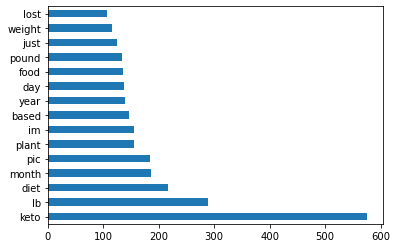

In [145]:
words_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

In [146]:
cv_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words='english')
cv_bigrams.fit(diets['title'])

bigrams_cv = cv_bigrams.transform(diets['title'])
bigrams_df = pd.DataFrame(bigrams_cv.todense(), columns=cv_bigrams.get_feature_names())

bigrams_df.sum().sort_values(ascending=False).head(15)

plant based      218
based diet        69
weight loss       54
months keto       52
sweet potato      45
progress pics     35
keto diet         35
face gains        34
lbs months        33
oil free          32
lbs lbs           31
lbs lost          30
lost lbs          28
brown rice        28
low carb          26
dtype: int64

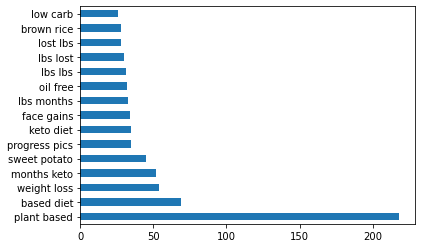

In [147]:
bigrams_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

In [148]:
cv_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words='english')
cv_trigrams.fit(diets['title'])

trigrams_cv = cv_trigrams.transform(diets['title'])
trigrams_df = pd.DataFrame(trigrams_cv.todense(), columns=cv_trigrams.get_feature_names())

trigrams_df.sum().sort_values(ascending=False).head(15)

plant based diet               68
food plant based               14
ive lost lbs                   11
eating plant based              9
plant based meal                8
rketo beginners community       7
community support thread        7
beginners community support     7
farmers market haul             6
hit goal weight                 6
bacon bacon bacon               6
ive lost pounds                 6
baked sweet potato              6
lbs months keto                 5
lbs face gains                  5
dtype: int64

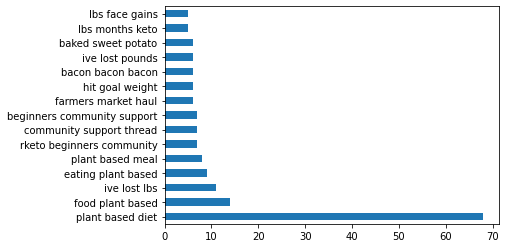

In [149]:
trigrams_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')

### Naive Bayes Model

In [150]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

In [151]:
nb = MultinomialNB()

In [152]:
nb.fit(X_train, y_train)

MultinomialNB()

In [153]:
nb.score(X_train, y_train), nb.score(X_test, y_test)

(0.8492476851851852, 0.8285378743394011)

In [154]:
preds = nb.predict(X_test)

In [155]:
confusion_matrix(y_test, preds)

array([[652, 175],
       [117, 759]], dtype=int64)

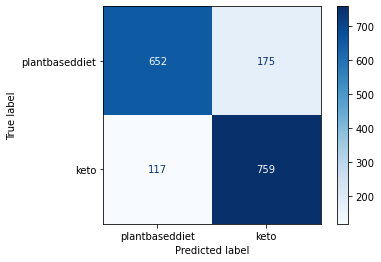

In [156]:
plot_confusion_matrix(nb, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['plantbaseddiet', 'keto']);

In [157]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [158]:
accuracy_score(y_test, preds)

0.8285378743394011

In [159]:
spec = tn / (tn + fp)
spec

0.788391777509069

In [160]:
recall = recall_score(y_test, preds)
recall

0.8664383561643836

In [161]:
precision = precision_score(y_test, preds)
precision

0.8126338329764454

#### Logistic Regression Model

In [162]:
from sklearn.linear_model import LogisticRegression

In [163]:
lr = LogisticRegression(C= 100)

In [164]:
lr.fit(X_train, y_train)

C:\Users\mason\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100)

In [165]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.8790509259259259, 0.810921902524956)

In [166]:
preds = lr.predict(X_test)

In [167]:
confusion_matrix(y_test, preds)

array([[632, 195],
       [127, 749]], dtype=int64)

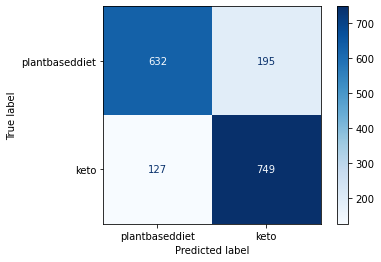

In [168]:
plot_confusion_matrix(lr, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['plantbaseddiet', 'keto']);

In [169]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [170]:
accuracy_score(y_test, preds)

0.810921902524956

In [171]:
spec = tn / (tn + fp)
spec

0.7642079806529625

In [172]:
recall = recall_score(y_test, preds)
recall

0.8550228310502284

In [173]:
precision = precision_score(y_test, preds)
precision

0.7934322033898306

#### Random Forest Classifier

In [174]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

In [175]:
rf = RandomForestClassifier(n_estimators=100)

In [176]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8275465731996018


{'max_depth': None, 'n_estimators': 200}

In [177]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9496527777777778, 0.8138578978273635)

In [178]:
preds = gs.predict(X_test)

In [179]:
confusion_matrix(y_test, preds)

array([[634, 193],
       [124, 752]], dtype=int64)

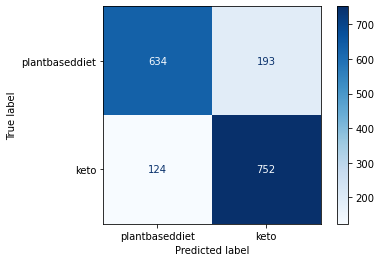

In [180]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['plantbaseddiet', 'keto']);

In [181]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [182]:
accuracy_score(y_test, preds)

0.8138578978273635

In [183]:
spec = tn / (tn + fp)
spec

0.7666263603385731

In [184]:
recall = recall_score(y_test, preds)
recall

0.8584474885844748

In [185]:
precision = precision_score(y_test, preds)
precision

0.7957671957671958

#### Extra Trees Classifier

In [186]:
et = ExtraTreesClassifier(n_estimators=100)

In [187]:
et.fit(X_train, y_train)

ExtraTreesClassifier()

In [188]:
et.score(X_train, y_train), et.score(X_test, y_test)

(0.9496527777777778, 0.8085731062830299)

In [189]:
preds = et.predict(X_test)

In [190]:
confusion_matrix(y_test, preds)

array([[643, 184],
       [142, 734]], dtype=int64)

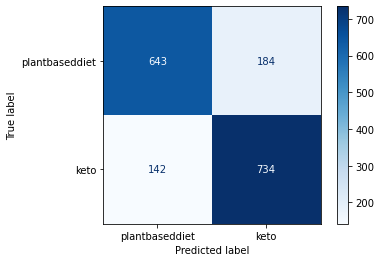

In [191]:
plot_confusion_matrix(et, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['plantbaseddiet', 'keto']);

In [192]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [193]:
accuracy_score(y_test, preds)

0.8085731062830299

In [194]:
spec = tn / (tn + fp)
spec

0.777509068923821

In [195]:
recall = recall_score(y_test, preds)
recall

0.8378995433789954

In [196]:
precision = precision_score(y_test, preds)
precision

0.7995642701525054

### Combined Confusion Matrix Analysis

|        Model        | TN  | FP  | FN  | TP  |
|:-------------------:|-----|-----|-----|-----|
| Naive Bayes         | 652 | 175 | 117 | 759 |
| Logistic Regression | 632 | 195 | 127 | 749 |
| Random Forest       | 634 | 193 | 124 | 752 |
| Extra Trees         | 643 | 184 | 142 | 734 |

|         Model         | Accuracy | Specificity | Sensitivity | Precision |
|:---------------------:|----------|-------------|-------------|-----------|
| Naïve   Bayes         |   0.82   |     0.78    |     0.86    |    0.81   |
| Logistic   Regression |   0.81   |     0.76    |     0.85    |    0.79   |
| Random   Forest       |   0.81   |     0.76    |     0.85    |    0.79   |
| Extra   Trees         |   0.81   |     0.77    |     0.83    |    0.79   |